# Домашнее задание 3. VAE + NF + VAPNEV

### Загрузка данных
В данном задании вам предстоит снова работать с CelebA

Решением домашки является архив с использованными тетрадками/модулями, а так же .pdf файл с отчетом по проделанной работе по каждому пункту задачи. В нем необходимо описать какие эксперименты вы производили чтобы получить результат который вы получили, а так же обосновать почему вы решили использовать штуки которые вы использовали (например, дополнительные лоссы для стабилизации, разные виды потоков, разные хаки для вае)



In [2]:
# from dataset import CelebADataset
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import tqdm
import os
from torch import nn

from torch import Tensor

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# t_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                    std=[0.229, 0.224, 0.225])
t_invnormalize = lambda x: (x + 1) / 2
# t_invnormalize = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
#                                                           std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
#                                      transforms.Normalize(mean=[-0.485, -0.456, -0.406],
#                                                           std=[1., 1., 1.]),
#                                      ])
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    lambda x: 2 * x - 1
])

In [4]:
import os
import zipfile
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import re
import numpy as np
import torch


class CelebADataset(Dataset):
    def __init__(self, root_dir='celeba', transform=None):
        """
        Args:
          root_dir (string): Directory with all the images
          transform (callable, optional): transform to be applied to each image sample
        """
        dataset_folder = f'{root_dir}/img_align_celeba/img_align_celeba/'
        self.dataset_folder = os.path.abspath(dataset_folder)
        self.transform = transform
        self.filenames = []
        with open(f'{root_dir}/list_attr_celeba.txt') as f:
            for i, line in enumerate(f.readlines()):
                line = re.sub(' *\n', '', line)
                if i == 0:
                    continue
                elif i == 1:
                    self.header = re.split(' +', line)
                else:
                    values = re.split(' +', line)
                    filename = values[0]
                    self.filenames.append(filename)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img_path = os.path.join(self.dataset_folder, img_name)
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

In [21]:
dataset = CelebADataset('/kaggle/input/celeba',transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)

img = dataset[0]
img.shape

torch.Size([3, 64, 64])

### Визуализация датасета

In [6]:
def plot_img(img, transform):
    plt.imshow(transform(img).permute(1, 2, 0))
    plt.axis('off')

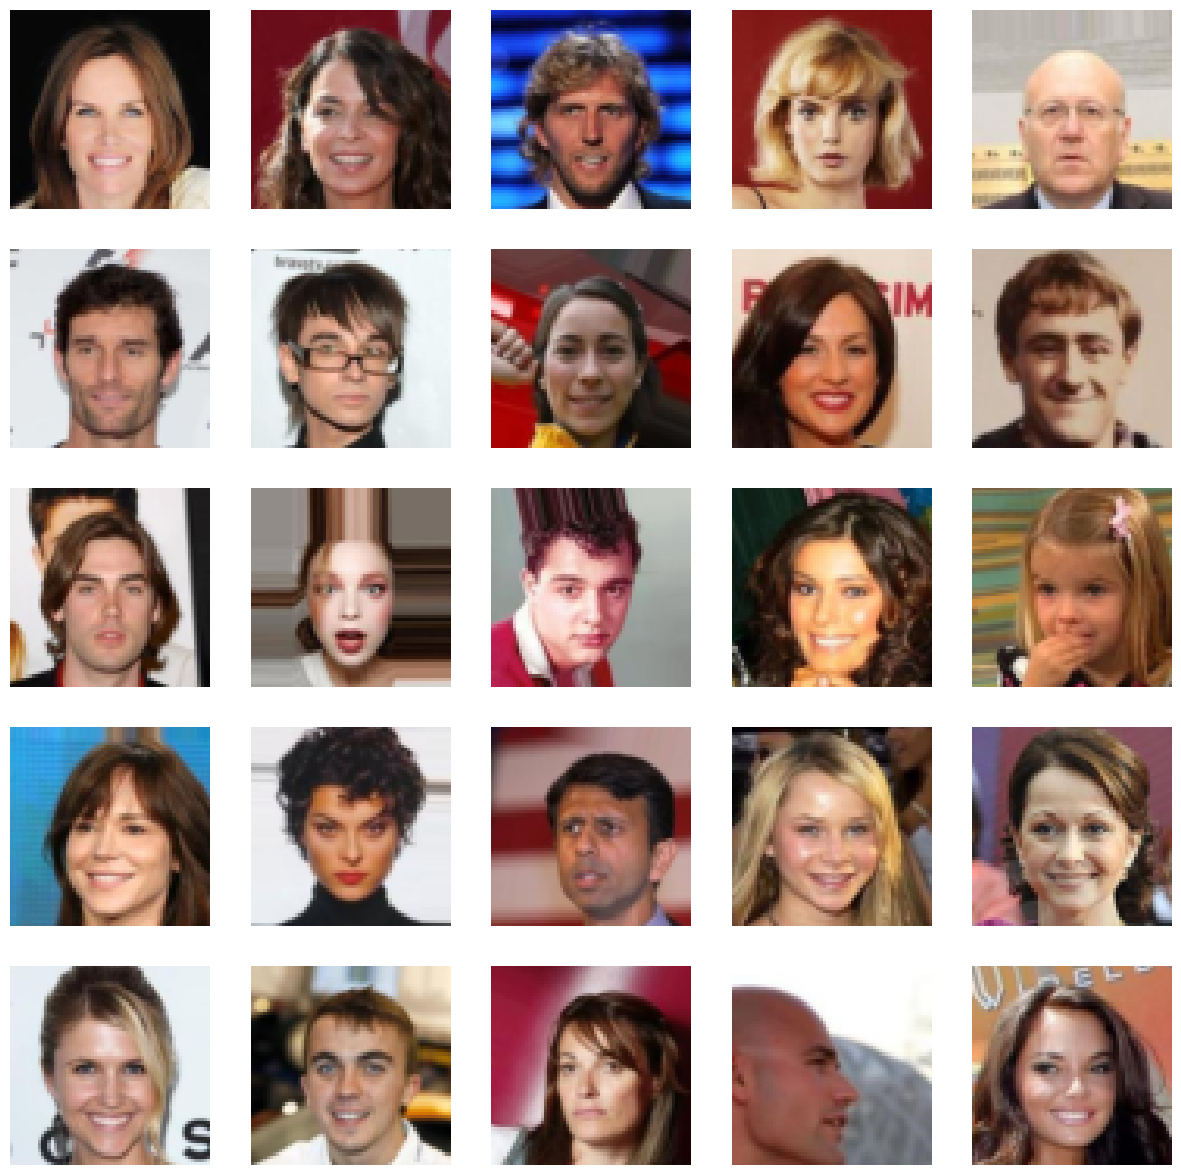

In [7]:
plt.figure(figsize=(15, 15))

for i in range(25):
    img = dataset[np.random.randint(len(dataset))]
    plt.subplot(5, 5, i + 1)
    plot_img(img, t_invnormalize)
plt.show()

### Задача 1 (4/10 балла). Построить и обучить нормпоток на CelebA

Здесь нужно обучить нормпоток до нормального (трешхолды будут позже) качества, померить FID и Negative Log Likelihood и запомнить для будущего сравнения

Внутри потока можно использовать все что вы хотите, Coupling/Autoregressive/Linear слои, любые трансформации и все что вам приходит в голову. Но все что вы используете - напишите сами, без копипаста.

Можно использовать как и сверточные потоки (будут лучше, но сложнее писать), так и линейные (будут хуже), развернув селебу в один вектор.

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

In [8]:
# YOUR CODE HERE

### Задача 2 (2/10 балла). Построить и обучить VAE на CelebA

Здесь нужно обучить VAE до нормального качества, померить FID и запомнить для будущего сравнения. 

В принципе можно использовать тот код который уже есть в репозитории курса, но лучше написать свой

Ради интереса, ваше вае тоже можно потестировать на маленьких датасетах


In [9]:
class Encoder(nn.Module):
    def __init__(self, dim, latent_dim, im_size):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, dim, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(dim),

            nn.Conv2d(dim, dim * 2, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(dim * 2),

            nn.Conv2d(dim * 2, dim * 4, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(dim * 4),

            nn.Conv2d(dim * 4, dim * 8, 4, 2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(dim * 8)
        )
        self.fc_mean = nn.Linear(dim * 8 * im_size * im_size // (16 ** 2), latent_dim)
        self.fc_logvar = nn.Linear(dim * 8 * im_size * im_size // (16 ** 2), latent_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.encoder(x).view(batch_size, -1)
        return self.fc_mean(out), self.fc_logvar(out)


class Decoder(nn.Module):
    def __init__(self, dim, latent_dim, im_size):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, dim * 8 * im_size * im_size // (16 ** 2)),
            nn.LeakyReLU(0.2, True),
        )
        self.decoder = nn.Sequential(
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(dim * 8, dim * 4, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(dim * 4, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(dim * 4, dim * 2, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(dim * 2, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(dim * 2, dim, 3, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(dim, 1.e-3),

            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(dim, 3, 3, padding=1)
        )
        self.tanh = nn.Tanh()

    def forward(self, z):
        batch_size = z.shape[0]
        out = self.fc(z).view(batch_size, -1, 64//16, 64//16)
        out = self.decoder(out)
        return self.tanh(out)


class VAE(nn.Module):
    def __init__(self, encoder_dim=32, decoder_dim=32, latent_dim=128, im_size=64, device=device):
        super(VAE, self).__init__()
        self.encoder = Encoder(encoder_dim, latent_dim, im_size).to(device)
        self.decoder = Decoder(decoder_dim, latent_dim, im_size).to(device)

    @staticmethod
    def reparameterize(mean, logvar):
        latent = torch.randn_like(mean)
        std = torch.exp(0.5 * logvar)
        return mean + std * latent

    def forward(self, x):
        mean, logvar = self.encoder(x)
        latent = self.reparameterize(mean, logvar)
        x_rec = self.decoder(latent)
        return x_rec, mean, logvar


vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), 0.0003)

In [10]:
def compute_loss(images, recon, mean, logvar):
    batch_size = images.shape[0]
    mse = F.mse_loss(recon.view(batch_size, -1), images.view(batch_size, -1), reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return mse + kl, mse, kl

In [11]:
from PIL import Image

def tensor2im(var):
    var = t_invnormalize(var).permute(1, 2, 0)
    var = var.cpu().detach().numpy()
    # var = ((var + 1) / 2)  # [-1,1]  --> [0,1]
    var[var < 0] = 0
    var[var > 1] = 1
    var = var * 255
    return Image.fromarray(var.astype('uint8'))

def parse_images(gen_img, display_count=2):
    im_data = []

    display_count = min(display_count, len(img))
    for i in range(display_count):
        cur_im_data = {
            'gen_image': tensor2im(gen_img[i]),
        }
        im_data.append(cur_im_data)

    return im_data
    
    
def vis_faces(log_hooks1):
    display_count = len(log_hooks1)
    fig = plt.figure(figsize=(6 * 2, 4 * display_count))
    gs = fig.add_gridspec(1, display_count)
    for i in range(display_count):
        hooks_dict1 = log_hooks1[i]

        fig.add_subplot(gs[i])
        plt.imshow(hooks_dict1['gen_image'])
        plt.title('gen_image')

    plt.tight_layout()
    return fig

In [15]:
epochs = 50


def train():
    vae.train()
    for epoch in tqdm(range(1, epochs + 1)):
        for images in tqdm(dataloader):
            images = images.to(device)
            optimizer.zero_grad()
            recon, mean, logvar = vae(images)
            loss, mse, kl = compute_loss(images, recon, mean, logvar)
            loss.backward()
            optimizer.step()
        torch.save(vae.state_dict(), f"vae_{epoch}.pth")
        torch.save(optimizer.state_dict(), f"optim.pth")

In [ ]:
train()

In [7]:
vae.load_state_dict(torch.load('vae_50.pth', map_location=device))

<All keys matched successfully>

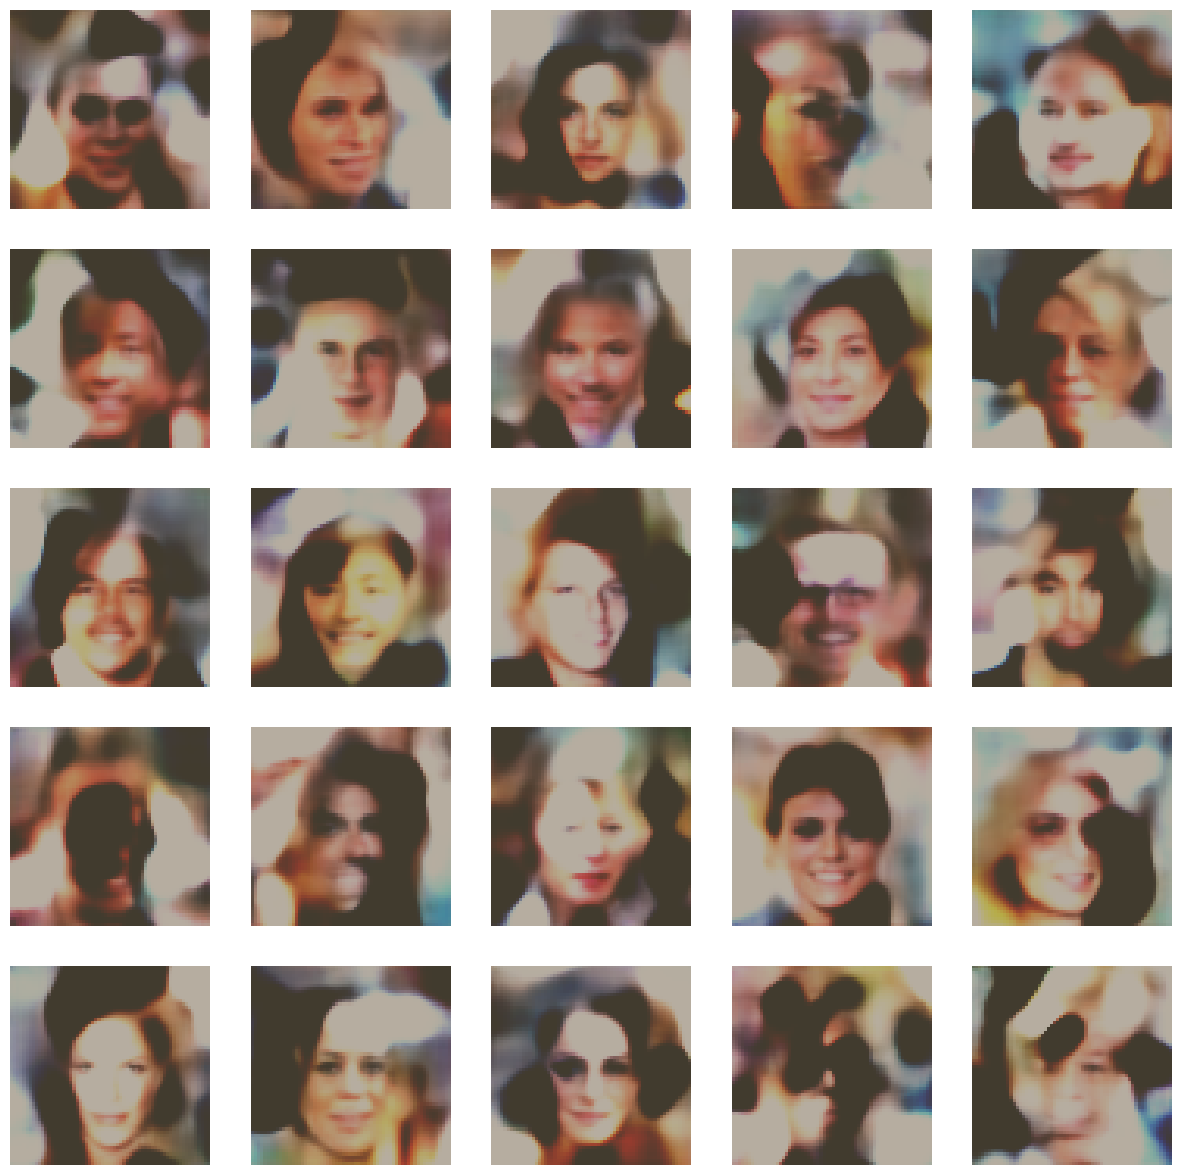

In [10]:
plt.figure(figsize=(15, 15))

for i in range(25):
    with torch.no_grad():
        z = torch.randn(1, 128).to(device)
        img = vae.decoder(z)
    plt.subplot(5, 5, i + 1)
    plot_img(img.cpu().squeeze(), t_invnormalize)
plt.show() 

Можно иначе нормализировать, но тогда лица получаются слишком контрасными(этот вариант мне больше нравится)

Далее я решил попробывать уменьшить коэф для KL и заменить mse на mae. Но что-то пошло не так

In [10]:
def compute_loss(images, recon, mean, logvar):
    batch_size = images.shape[0]
    mse = F.l1_loss(recon.view(batch_size, -1), images.view(batch_size, -1), reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return mse + 0.1 * kl, mse, kl

In [11]:
epochs = 50


def train():
    vae.train()
    for epoch in tqdm(range(1, epochs + 1)):
        for images in tqdm(dataloader):
            images = images.to(device)
            optimizer.zero_grad()
            recon, mean, logvar = vae(images)
            loss, mse, kl = compute_loss(images, recon, mean, logvar)
            loss.backward()
            optimizer.step()
            
        plt.figure(figsize=(15, 15))
        for i in range(25):
            with torch.no_grad():
                z = torch.randn(1, 128).to(device)
                img = vae.decoder(z)
            plt.subplot(5, 5, i + 1)
            plot_img(img.cpu().squeeze(), t_invnormalize)
        plt.show()
        torch.save(vae.state_dict(), f"vae_{epoch}_mae_01.pth")
        torch.save(optimizer.state_dict(), f"optim_mae_01.pth")

In [ ]:
train()

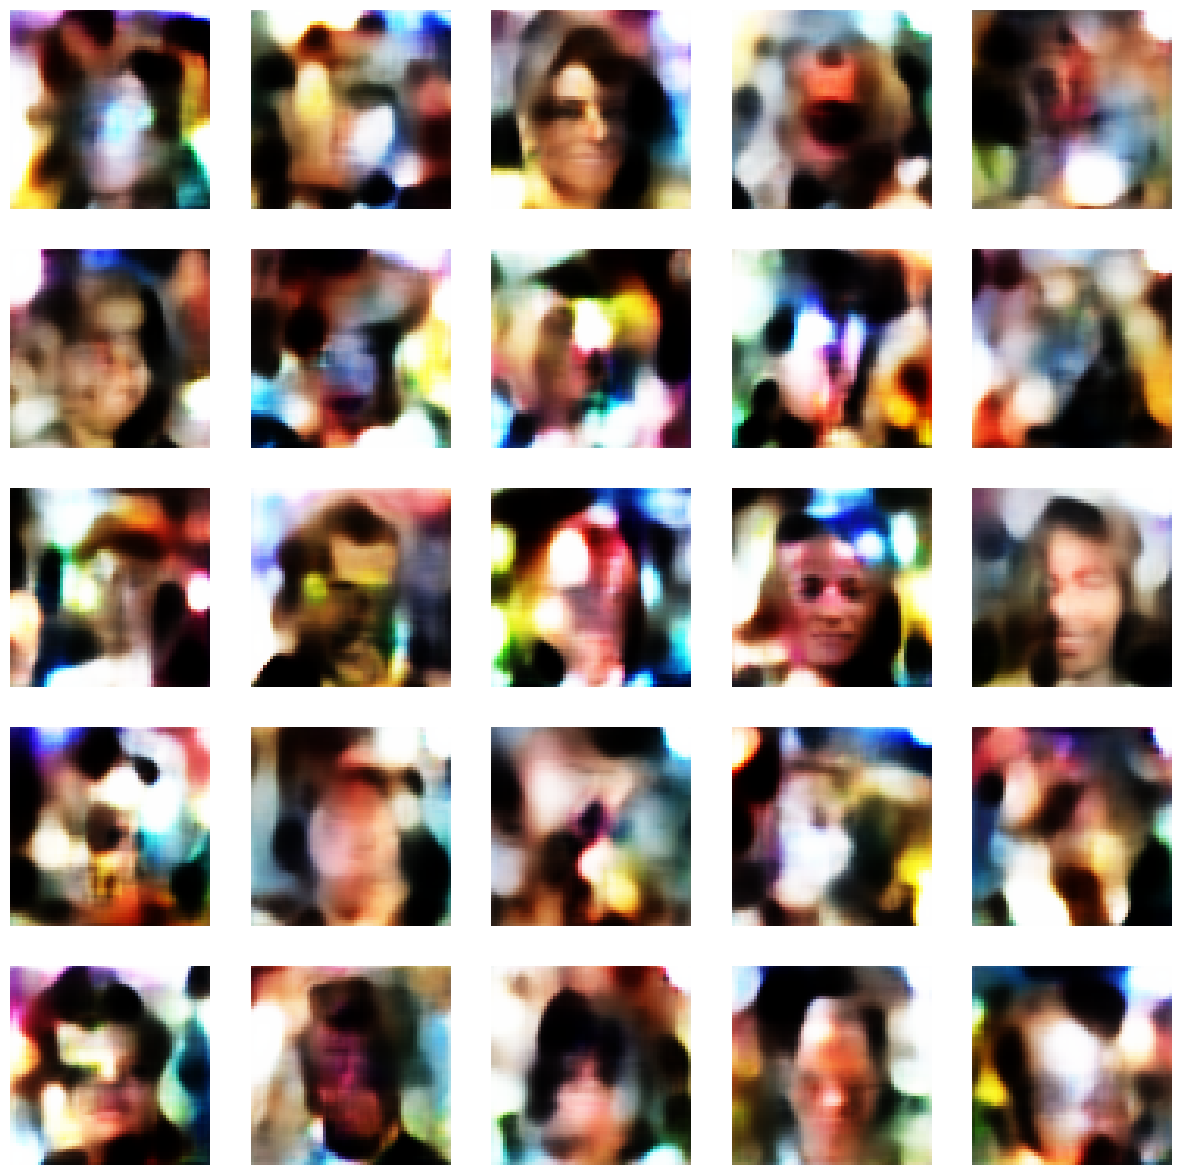

In [27]:
from scipy.linalg import sqrtm
def calculate_fid(repr1, repr2):
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)

    cov1 = np.cov(repr1.T)
    cov2 = np.cov(repr2.T)

    sqrt_cov = sqrtm(cov1 @ cov2)

    return np.linalg.norm(mu1 - mu2) ** 2 + np.real(np.trace(cov1 + cov2 - 2 * sqrt_cov))

In [ ]:
import torchvision
vae.load_state_dict(torch.load('vae_50.pth'))
vae.eval()
model = torchvision.models.mobilenet_v2(pretrained=True).to(device)
model.eval()
activations_size = 5120
p1 = np.empty(((len(dataloader) - 1) * dataloader.batch_size, activations_size))
p2 = np.empty_like(p1)
index = 0
for batch in tqdm(dataloader):
    batch = batch.to(device)
    a1 = model.features(batch).detach().cpu().numpy().reshape(batch.shape[0], -1)
    z = torch.randn(batch.shape[0], 128).to(device)
    fake = vae.decoder(z)
    a2 = model.features(fake).detach().cpu().numpy().reshape(batch.shape[0], -1)
    p1[index: index + batch.shape[0]] = a1[:, :activations_size]
    p2[index: index + batch.shape[0]] = a2[:, :activations_size]
    index += dataloader.batch_size

    if index >= len(p1):
        break

In [28]:
calculate_fid(p1, p2)

1371.460694848764

### Задача 3 (6/10 балла). 

#### Задача 3.1 (4/10 балла) Построить и обучить VAPNEV на CelebA

Здесь нужно прочитать [статью про VAPNEV](https://arxiv.org/pdf/1611.05209.pdf), обучить его до нормального (трешхолды будут позже) качества, померить FID и запомнить для будущего сравнения. 

#### Задача 3.2 (2/10 балла). Построить и обучить conditional VAPNEV на CelebA

Вроде понятно из текста задачи. Что такое conditional VAPNEV, читайте в статье

In [ ]:
# YOUR CODE HERE

### Задача 4. (1/10 балла) Анализ

* Анализ латентного пространства и визуально качественный результат - **1 балл**
1. Посмотрите у какой модели получается лучшая интерполяция в латентном пространстве
2. Попробуйте взять внешнюю картинку (не из селебы), отмапить ее с латентное пространство и покажите ближайшие к ней.
3. Покажите самый смешной результат генерации который у вас получался

In [ ]:
# YOUR CODE HERE

### Задача 0. Отчет

Чтобы получить полный балл за каждый из пунктов вам нужно включить в отчет (который сдатеся отдельно в виде pdf) примеры (лучше - много примеров) генерации вашей модели. 

Сравните результаты разных моделей, попробуйте обьяснить почему одна сработала лучше чем другая.